In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings

from scipy.integrate import odeint
from IPython.display import Image

# Sklearn specific functions used in this lecture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score

import shap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

### 1. 
Salinity, or specific conductance (SC), is a key water quality parameter in rivers, and it is influenced by water levels, including both flood and drought conditions. In the study by Ombadi & Varadharajan (Water Research, 2022), the authors examine how floods impact salinity levels across 259 rivers in the contiguous United States. The folder "HW4_data" contains data for 10 of these rivers in CSV format. Each file includes five predictors (SC_(τ=5), SC_(τ=120), runoff_(τ=5), runoff_(τ=120), and runoff) and one target variable (SC). Here, τ represents the number of lagged days, SC stands for specific conductance (measured in μS/cm), and runoff is in cubic feet per second (cfs).

### 1）
For the first two sites (site_1.csv and site_2.csv), create scatterplots of runoff versus
SC. [Hint: Use a log-log scale for better visualization.] Describe the general
relationship pattern you observe.

In [6]:
# read the data of two sites
data_1 = pd.read_csv('site_1.csv')
data_2 = pd.read_csv('site_2.csv')
data_1

,datetime,runoff_5,runoff_120,sc_5,sc_120,runoff,sc
0,1/24/99,87.40,20.56,88.78,106.14,196,72.15
1,1/25/99,101.20,22.17,85.17,105.42,352,51.14
2,2/3/99,59.00,30.34,68.08,97.01,242,66.05
3,2/4/99,93.80,32.35,69.07,96.04,189,61.04
4,3/4/99,102.40,47.66,68.99,85.35,304,55.76
...,...,...,...,...,...,...,...
398,5/6/21,115.02,59.52,46.15,68.67,193,22.72
399,5/31/21,69.02,57.43,89.10,69.82,224,35.47
400,6/1/21,110.38,59.02,72.09,69.48,192,23.46
401,7/10/21,76.14,57.65,55.10,78.40,210,35.07


In [7]:
data_2

,datetime,runoff_5,runoff_120,sc_5,sc_120,runoff,sc
0,1/25/98,89.20,23.33,124.80,172.75,237,149.77
1,2/19/98,107.60,41.82,122.33,160.95,258,120.50
2,2/25/98,158.60,50.23,111.67,157.89,263,121.43
3,3/2/98,206.80,58.45,106.01,156.40,229,96.38
4,3/3/98,200.00,59.95,101.00,156.05,226,93.37
...,...,...,...,...,...,...,...
412,12/25/20,27.96,14.43,367.81,243.10,487,263.17
413,12/26/20,119.84,18.46,367.20,243.55,644,91.16
414,12/27/20,243.00,23.79,306.59,242.83,304,106.15
415,5/31/21,73.68,61.31,174.69,147.59,233,83.46


Text(0, 0.5, 'Log(sc) [log10(μS/cm)]')

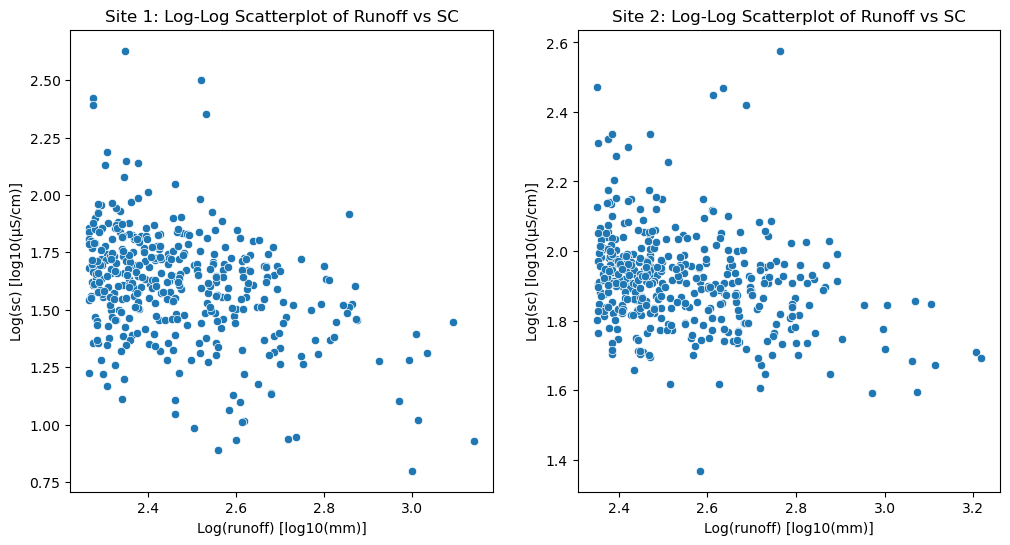

In [14]:
# create a log-log scatter plot for data_1
plt.figure(figsize=(12, 6))

# log runoff and sc for data_1
data_1['log_runoff'] = np.log10(data_1['runoff'])
data_1['log_sc'] = np.log10(data_1['sc'])

plt.subplot(1, 2, 1)
sns.scatterplot(x='log_runoff', y='log_sc', data=data_1)
plt.title('Site 1: Log-Log Scatterplot of Runoff vs SC')
plt.xlabel('Log(runoff) [log10(mm)]')
plt.ylabel('Log(sc) [log10(μS/cm)]')

# log runoff and sc for data_2
data_2['log_runoff'] = np.log10(data_2['runoff'])
data_2['log_sc'] = np.log10(data_2['sc'])

plt.subplot(1, 2, 2)
sns.scatterplot(x='log_runoff', y='log_sc', data=data_2)
plt.title('Site 2: Log-Log Scatterplot of Runoff vs SC')
plt.xlabel('Log(runoff) [log10(mm)]')
plt.ylabel('Log(sc) [log10(μS/cm)]')

**Site 1**
- There is a negative relationship between 'runoff' and 'sc'. As runoff increases, sc decreases, but the points are quite spread out, particularly in the 'runoff' is bigger.
- Most of 'sc' are distributed in low runoff values(<2.6 log10(mm)), and the distribution range of 'sc' which correspond each 'runoff' is wide.
- Over a certain runoff threshold (>2.8 log10(mm)), SC values sharply drop and scatter more sparsely.

**Site 2**
- A similar negative relationship is visible, though less pronounced compared to Site 1. The majority of points are clustered in the lower runoff range (<2.8 log10(mm)), with a wide spread of 'sc' values.
- There’s a denser cluster around runoff(<2.5 log10(mm)), where sc tends to stabilize around 1.8–2.0 log10(μS/cm).
- The relationship weakens at higher runoff values, with more dispersed sc values.

In both sites, as runoff increases, sc generally decreases, but the relationship varies in strength and scatter across the two sites.

### 2）
Calculate the Spearman correlation coefficient between runoff and SC for each of
the 10 sites. Does the correlation value align with the general pattern you observed
in the scatterplots for the first two sites?

In [21]:
from scipy.stats import spearmanr

# create a place to save each correlation for sites
spearman_corrs = {}

# create a loopy
for i in range(1, 11):
    # read in all date for each site
    site_data = pd.read_csv(f'site_{i}.csv')

    # compute the corr of 'runoff' and 'sc'
    corr, _ = spearmanr(site_data['runoff'], site_data['sc'])
    corr_5, _ = spearmanr(site_data['runoff_5'], site_data['sc_5'])
    corr_120, _ = spearmanr(site_data['runoff_120'], site_data['sc_120'])

    # output the corrs of every site
    print(f'site_{i}:')
    print(f' Spearman correlation coefficient between runoff and sc = {corr:.3f}')
    print(f' Spearman correlation coefficient between runoff_5 and sc_5 = {corr_5:.3f}')
    print(f' Spearman correlation coefficient between runoff_120 and sc_120 = {corr_120:.3f}\n')                  

site_1:
 Spearman correlation coefficient between runoff and sc = -0.333
 Spearman correlation coefficient between runoff_5 and sc_5 = -0.684
 Spearman correlation coefficient between runoff_120 and sc_120 = -0.568

site_2:
 Spearman correlation coefficient between runoff and sc = -0.291
 Spearman correlation coefficient between runoff_5 and sc_5 = -0.626
 Spearman correlation coefficient between runoff_120 and sc_120 = -0.684

site_3:
 Spearman correlation coefficient between runoff and sc = -0.361
 Spearman correlation coefficient between runoff_5 and sc_5 = -0.339
 Spearman correlation coefficient between runoff_120 and sc_120 = -0.353

site_4:
 Spearman correlation coefficient between runoff and sc = -0.275
 Spearman correlation coefficient between runoff_5 and sc_5 = -0.504
 Spearman correlation coefficient between runoff_120 and sc_120 = -0.567

site_5:
 Spearman correlation coefficient between runoff and sc = -0.295
 Spearman correlation coefficient between runoff_5 and sc_5 = -

Yes, the correlation value align with the general pattern I observed in the scatterplots for the first two sites. This is because the spearman correlation coefficient of this two sits are negative value. As the sc increases, runoff will decreases. Also the runoff increases sc will decreases in both two scatterplots. The absolute value of the Spearman correlation coefficient of site_1 is higher than that of site_2, so the degree of correlation is higher than that of site_2, which is also consistent with the observation in the scatterplots.

### 3）
Explain the physical mechanism behind the relationship between runoff and SC.
[Hint: Refer to the abstract and introduction sections of the Ombadi &
Varadharajan article.]

- Though the Ombadi & Varadharajan article, we could know that the dilution effect is the main mechanism of sc decline during the floods. When the rainfall is high so the runoff will increases, the water will enters the river channel, diluting the dissolved ions which have existed, thereby reducing sc. This is especially true in areas that are non-arid and free of pollution made by people.
- In mining areas or high pollution areas, the surface of these areas may have accumulated salts or minerals. Therefore, when the flood washed, this salts and minerals will be carried into the river, causing in an increase insc.
- The sc level in the days before the flood have an important influence on sc changes. The higher the sc level before the flood, the more signficant the dilution effect and the greater the change in sc value. In addition, a 'time-lag' effect means that the chemical response during flooding may lag behind the increase in water.
- Different climate, land use, and hydrological conditions can cause sc to respond differently to flooding. As the Ombadi & Varadharajan article shows in temperate urban areas, more hardening of the surface leads to rapid diluting effects of flooding, but in arid mining areas, salt accumulates more, and when the flood washes away, a large number of dissolved ions are brought in to increase sc.

### 2.
For the first site (site_1.csv), build a regression tree model to predict SC using the five
given predictors.
### 1）
Split the data, allocating 75% for training and 25% for testing, and use the default
settings of the sklearn.DecisionTreeRegressor function. Evaluate the model's
performance using R², RMSE, Pearson’s correlation coefficient, and relative bias.

In [22]:
from scipy.stats import pearsonr
data = pd.read_csv('site_1.csv')
data

,datetime,runoff_5,runoff_120,sc_5,sc_120,runoff,sc
0,1/24/99,87.40,20.56,88.78,106.14,196,72.15
1,1/25/99,101.20,22.17,85.17,105.42,352,51.14
2,2/3/99,59.00,30.34,68.08,97.01,242,66.05
3,2/4/99,93.80,32.35,69.07,96.04,189,61.04
4,3/4/99,102.40,47.66,68.99,85.35,304,55.76
...,...,...,...,...,...,...,...
398,5/6/21,115.02,59.52,46.15,68.67,193,22.72
399,5/31/21,69.02,57.43,89.10,69.82,224,35.47
400,6/1/21,110.38,59.02,72.09,69.48,192,23.46
401,7/10/21,76.14,57.65,55.10,78.40,210,35.07


In [33]:
# Features (X) and Target (y)
X = data[['runoff_5', 'runoff_120', 'sc_5', 'sc_120']]
y = data['sc']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the Decision Tree Regressor
regressor = DecisionTreeRegressor()

# Train the regressor
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
pearson_corr, _ = pearsonr(y_test, y_pred)
relative_bias = np.mean(y_pred - y_test) / np.mean(y_test) * 100

# Print performance metrics
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Pearson’s correlation coefficient: {pearson_corr:.3f}")
print(f"Relative bias: {relative_bias:.2f}%")

R²: 0.131
RMSE: 44.289
Pearson’s correlation coefficient: 0.390
Relative bias: -10.03%


### 2）
Next, train the regression tree model 100 times with the same data split. For each
run, record the R² value. Then, plot a histogram of the 100 R² values. [Hint: Ensure
that random_state=None is set, which is the default setting.]

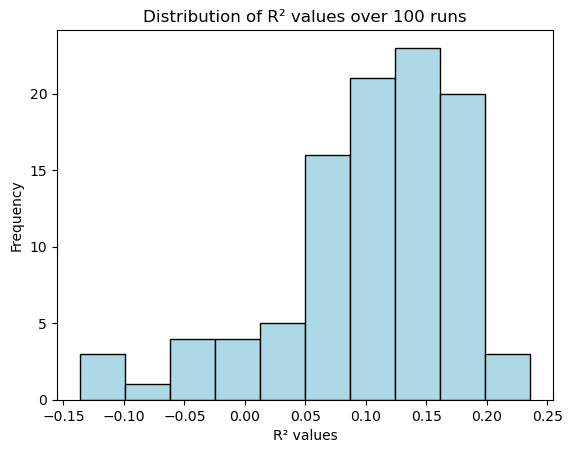

In [35]:
r2_values = []
# create a loopy
for _ in range(100):
    # Ensure no fixed random state
    regressor = DecisionTreeRegressor(random_state=None)  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    r2_values.append(r2_score(y_test, y_pred))

# Plot a histogram of the R² values
plt.hist(r2_values, bins=10, color='lightblue', edgecolor='black')
plt.xlabel("R² values")
plt.ylabel("Frequency")
plt.title("Distribution of R² values over 100 runs for Decision Tree")
plt.show()

### 3.
For the same site in Question 2 (site_1.csv), build a random forest model to predict SC
using the five predictors. Split the data, assigning 75% for training and 25% for testing.
Use the following parameter values for the random forest model: n_estimators=150,
max_depth=10, min_samples_split=2, and random_state=None.

### 1)
Evaluate the model’s performance using R², RMSE, Pearson’s correlation
coefficient, and relative bias.

In [38]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=2, random_state=None)

# Train the Random Forest model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
relative_bias = np.mean(y_pred - y_test) / np.mean(y_test) * 100

# Print performance metrics
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Pearson’s correlation coefficient: {pearson_corr:.3f}")
print(f"Relative bias: {relative_bias:.2f}%")

R²: 0.336
RMSE: 44.289
Pearson’s correlation coefficient: 0.587
Relative bias: -0.40%


### 2)
Train the random forest model 100 times using the same data split. For each run,
record the R² value and then plot a histogram of the 100 R² values.

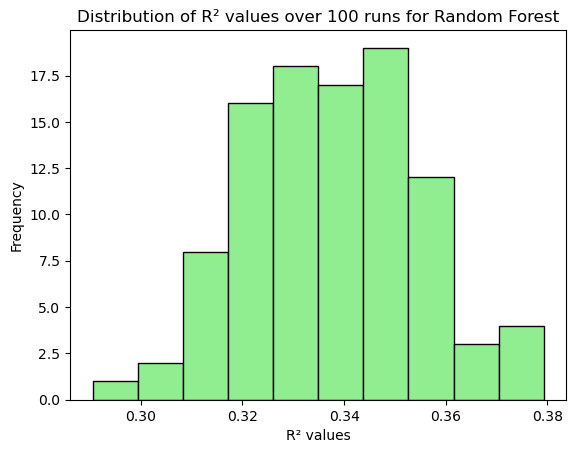

In [39]:
r2_values = []
# create a loopy
for _ in range(100):
    # Ensure no fixed random state
    rf_regressor = RandomForestRegressor(random_state=None)  
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    r2_values.append(r2_score(y_test, y_pred))

# Plot a histogram of the R² values
plt.hist(r2_values, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel("R² values")
plt.ylabel("Frequency")
plt.title("Distribution of R² values over 100 runs for Random Forest")
plt.show()

### 3)
Compare this histogram with the one you obtained from the regression tree model
in Question 2. What are your observations? If the two histograms differ, explain
the reasons for the difference

- For the histogram of random forest, the distribution of R² range around 0.30 to 0.38, which most values in center are closed to nomalization distribution. This shows that the random forest model has higher predictive performance and consistency over multiple runs.
- For the histogram of decision tree, the distribution of R² valuse are centered around 0.10 to 0.15, and some runs even yield negative R² values. This reflects a less accurate and more variable model.
- For the reason of the difference, the random forest model generally perform better because it aggregates predictions from multiple trees, it reduces overfitting and variability. In contrast, decision trees are more prone to overfitting, especially when used alone, and may not generalize well to previously unseen data. Also, due to the ensemble nature of the random forest model, it also shows more consistent results across different runs, while regression trees show greater variability, as seen from the wider distribution of R² values, some of which are negative indicating poor fit.

### 4.
For the same site in Question 2 (site_1.csv), build a random forest model to predict SC
using the five predictors.

### 1)
This time, use the first half of the observations for training and the second half for
testing. Evaluate the model’s performance by calculating the R² value for the
predictions on the testing data.

In [41]:
# Split the data into two halves
split_index = len(X) // 2
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=2, random_state=None)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
# Evaluate the model
r2 = r2_score(y_test, y_pred)

# Print performance of R²
print(f"R² for site_1: {r2:.3f}")

R² for site_1: 0.241


### 2)
Construct a random forest model and train it on data from all 10 sites. Extract the
first half of the data from each site, normalize the data to have zero mean and unit
standard deviation, and then combine the data from all 10 sites. Note: A machine
learning model trained on data from multiple sites is often referred to as a regional
model. Use this regional random forest model to predict the second half of the data for
site_1 and calculate the R² value.

In [52]:
from sklearn.preprocessing import StandardScaler

# Load data from all 10 sites
sites = []
for i in range(1, 11):
    site_data = pd.read_csv(f'site_{i}.csv')
    sites.append(site_data)

# Combine the first half of the data from all 10 sites
X_combined = pd.DataFrame()
y_combined = pd.Series()
for site_data in sites:
    X_site = site_data[['runoff', 'runoff_5', 'runoff_120', 'sc_5', 'sc_120']]
    y_site = site_data['sc']
    
    # Use the first half for training
    X_combined = pd.concat([X_combined, X_site.iloc[:len(X_site) // 2]])
    y_combined = pd.concat([y_combined, y_site.iloc[:len(y_site) // 2]])

# Normalize the combined dataset
scaler = StandardScaler()
X_combined_normalized = scaler.fit_transform(X_combined)

# Train the Random Forest model on the combined dataset
rf_model_regional = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=2, random_state=None)
rf_model_regional.fit(X_combined_normalized, y_combined)

# For site_1 extract the second half as the test set
site_1 = pd.read_csv('site_1.csv')
X_test_site_1 = site_1[['runoff', 'runoff_5', 'runoff_120', 'sc_5', 'sc_120']].iloc[len(site_1) // 2:]
y_test_site_1 = site_1['sc'].iloc[len(site_1) // 2:]

# Normalize the test data for site_1 using the same scaler
X_test_site_1_normalized = scaler.transform(X_test_site_1)

# Make predictions on the second half of site_1 using the regional model
y_pred_regional = rf_model_regional.predict(X_test_site_1_normalized)

# Calculate R² for site_1
r2_regional = r2_score(y_test_site_1, y_pred_regional)
print(f"R² for regional model on site_1: {r2_regional}")

R² for regional model on site_1: -0.2039421117433453


### 3)
Does the model trained on data from 10 sites outperform the model trained on site_1
alone? If so, why?

No, the model trained on data from 10 sites does not outperform the model trained on site_1 alone. 
- For the Regional Model of all sites, The negative \( R^2 \) value indicates that the regional model performs worse than the model only using site_1 data.

- For the site-specific model had a positive \( R^2 \) value, which indicates some predictive power, even if the score is not very high. This shows that the model trained data from site_1 captures the patterns relevant to site_1 better than the generalized regional model.

### Why?
- Different sites have varying environmental, hydrological, or geographical characteristics. While combining data from all sites into a regional model can be useful when sites share similar characteristics, it can be detrimental if the sites are too different. The regional model likely overfits patterns from the other sites that are not applicable to site_1, thus reducing its accuracy on site_1.

- When sites have similar characteristics, Site_1 may have unique factors affecting runoff and sc that are not well represented at other sites. A site-specific model can better capture these local factors because it trains only data related to site_1